In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Claus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Claus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Claus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [97]:
df = pd.read_csv('../data/IMDB Dataset.csv')

In [91]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Exploration

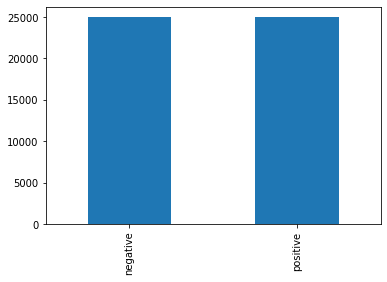

In [4]:
# vis histogram med fordelingen af positive og negative anmeldelser.
# For at sikre at datasættet ikke er skævt.
df['sentiment'].value_counts().sort_index().plot.bar()

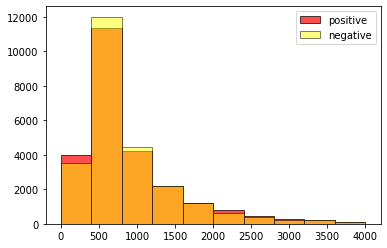

In [221]:
#Kontroller længden af positive kontra negative
#Normal distribution af fordelingen af længderne af reviews
df_positive = df[df['sentiment']=='positive']
df_negative = df[df['sentiment']=='negative']
pos_series = df_positive['review'].str.len()
neg_series = df_negative['review'].str.len()

pos = plt.hist(pos_series, range=[0,4000], color='red', edgecolor='black', alpha=0.7, label='positive')
neg = plt.hist(neg_series, range=[0,4000], color='yellow', edgecolor='black', alpha=0.5, label='negative')
plt.legend()




## Data preprocessing

In [98]:
# Lowercase all reviews
def lowercase(df:pd.DataFrame, column:str):
    df[column] = df[column].str.lower()

lowercase(df, 'review')
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [102]:
# Remove html tags in review column with regex
def removeHtml(df:pd.DataFrame) -> pd.DataFrame:
    df = df.replace(to_replace ='<[^>]*>', value = '', regex = True)
    return df

df = removeHtml(df)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [103]:
# Remove stopwords
def removeStopwords(df:pd.DataFrame, column:str):
    stop = stopwords.words('english')
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

removeStopwords(df, 'review')
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production. filming technique...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there's family little boy (jake) thi...,negative
4,"petter mattei's ""love time money"" visually stu...",positive


In [9]:
# Lemmatization
lemma = WordNetLemmatizer()
punctuations="?:!.,;`´"
def lemmatization(sentence):
    words = word_tokenize(sentence)
    for word in words:
        if word in punctuations:
            words.remove(word)
    res = map(lambda word: lemma.lemmatize(word, pos="v"), words)
    return " ".join(list(res))
    

df['review'] = df['review'].apply(lambda x: lemmatization(x))
df.head()

,review,sentiment
0,one reviewers mention watch 1 oz episode hook ...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically there 's family little boy ( jake ) ...,negative
4,petter mattei 's `` love time money '' visuall...,positive


In [10]:
"""
# Stemming words in reviews
ps = PorterStemmer()

def stemming(sentence):
    words = word_tokenize(sentence)
    res = map(lambda x: ps.stem(x), words)
    return " ".join(list(res))
        
df['review'] = df['review'].head().apply(lambda x: stemming(x))
df.head()
"""

'\n# Stemming words in reviews\nps = PorterStemmer()\n\ndef stemming(sentence):\n    words = word_tokenize(sentence)\n    res = map(lambda x: ps.stem(x), words)\n    return " ".join(list(res))\n        \ndf[\'review\'] = df[\'review\'].head().apply(lambda x: stemming(x))\ndf.head()\n'

In [11]:
df.shape

(50000, 2)

In [12]:
X_train, X_test = df[:40000], df[40000:]
X_test

,review,sentiment
40000,first want say lean liberal political scale fi...,negative
40001,excite see sitcom would hopefully represent in...,negative
40002,look cover read stuff entirely different type ...,negative
40003,like many others count appearance dennis hoppe...,negative
40004,movie t.v day enjoy all first george jungle go...,negative
...,...,...
49995,think movie right good job creative original f...,positive
49996,bad plot bad dialogue bad act idiotic direct a...,negative
49997,catholic teach parochial elementary school nun...,negative
49998,i 'm go disagree previous comment side maltin ...,negative


In [13]:
# Convert seentiment to numeric. In this case, 0 for positive and 1 for negative
sentiment_label = df.sentiment.factorize()
sentiment_label

(array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

In [14]:
# Assign a number to each word and replace with that number in the sentence

# Get the actual texts from the data frame
review = df.review.values
# Initialize the tokenizer with a 10000 word limit. This is the number of words we would like to encode
tokenizer = Tokenizer(num_words=10000)
# Call fit_on_texts to create associations of words and numbers.
tokenizer.fit_on_texts(review) # all reviews.

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
# As the model input requires to have equal length, the sequence is padded to have a length
padded_sequence = pad_sequences(encoded_docs, maxlen=200) # df.max? for at få længste review...

In [15]:
# Review and the corresponding numeric representation of it
print(review[0][:200])
print(padded_sequence[0])

one reviewers mention watch 1 oz episode hook right exactly happen me.the first thing strike oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pull punc
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    5 1877  373   15  245 2806  347
 1618  125  565  117  158   17   35   80 1054 2806 4725   68  522  104
  125  299   16 1375  158   23 5321 2110 9771   23  601 1683 1106  632
  322  522 3384  312   73  299   13  180 2806 7036   36 5973 2308  534
  581 1318  484 4124 1937 1107 6091 1821  868  229  237 4314 6299  484
  285   51 7037 4418 6712 2217  521  209  272   90 6404  393 7472   54
  156  177   10   19   28  217  812   23  633  123   16   23 1515  424
  112  287 1065 2284 1137  424  644  424  756 2806  729  114   35  347
   60  140 1054 1481 2038   28 1447   13   15  521  700 1001 2806    9
 8688  237  483 19

In [16]:
# Build the model

embedding_vector_length = 32 # length of output dimension

model = Sequential()

# add layers to model
model.add(Embedding(vocab_size, embedding_vector_length, input_length=len(padded_sequence[0]))) # ord 'scores' baseret på positioner og omgivende ord i review tekster. 
model.add(SpatialDropout1D(0.25)) 
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # giver en rating af hvor pos/neg et review er.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # adam er algoritmen hvormed vægte mv. justeres for at minimere loss. (Gradient descent). 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           3257472   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,274,123
Trainable params: 3,274,123
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(padded_sequence,sentiment_label[0],
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1250/1250 [==============================] - 384s 304ms/step - loss: 0.4577 - accuracy: 0.7682 - val_loss: 0.2740 - val_accuracy: 0.8893
Epoch 2/5
1250/1250 [==============================] - 384s 307ms/step - loss: 0.2540 - accuracy: 0.9022 - val_loss: 0.2787 - val_accuracy: 0.8904
Epoch 3/5
1250/1250 [==============================] - 352s 282ms/step - loss: 0.2188 - accuracy: 0.9165 - val_loss: 0.2754 - val_accuracy: 0.8854
Epoch 4/5
1250/1250 [==============================] - 383s 306ms/step - loss: 0.1935 - accuracy: 0.9282 - val_loss: 0.3042 - val_accuracy: 0.8919
Epoch 5/5
1250/1250 [==============================] - 366s 293ms/step - loss: 0.1749 - accuracy: 0.9337 - val_loss: 0.2827 - val_accuracy: 0.8869


In [110]:
def analyze_sentence(sentence):
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    pred = model.predict(tw)
    prediction = int(pred.round().item())
    print(pred)
    return sentiment_label[1][prediction]

In [111]:
print(analyze_sentence("I saw this when it first came out and was shocked even then by the complete failure of the Hollywood hacks who made the film to either put Conan on the screen or even just make a decent movie. Phew. Recently, I tried to watch it again, twenty-odd years later - and I gagged. It's irredeemable. It's on a par with Plan 9. Only it's more boring."))

[[0.8328366]]
negative


In [20]:
model.save('./imdb_sentiment_analyzer')

INFO:tensorflow:Assets written to: ./imdb_sentiment_analyzer\assets


In [174]:
def analyze_sentence2(sentence:str, sentiment_score:int, serie):
    if sentiment_score == -1:
        sentiment_score = 0
    serie[0].append(sentiment_score)
    
    tw = tokenizer.texts_to_sequences([sentence])
    tw = pad_sequences(tw, maxlen=200)
    pred = model.predict(tw)
    prediction = int(pred.round().item())        
    serie[1].append(sentiment_label[1][prediction])

series = [[],[]]
for text, sentiment in X_test.values[:100]:
    analyze_sentence2(lemmatization(text), sentiment, series)


In [214]:
def scatterPrediction(predicted:list, actual:list):      
    for x,y in enumerate(predicted):
        pre = plt.scatter(x,y, label="Predicted", color='white', edgecolor='red', s=200)
    for x,y in enumerate(actual):
        act = plt.scatter(x,y, label="Actual", color='green')
        plt.legend((pre, act), ('predicted', 'actual'))

# def scatterPrediction2(predicted:list, actual:list):
#     plt.figure(figsize=figsize)
#     for x, (y,z) in enumerate(zip(predicted, actual)):
#         if (y == z):
#             plt.scatter(x,y)

Text(0.5, 1.0, 'Test Dataset')

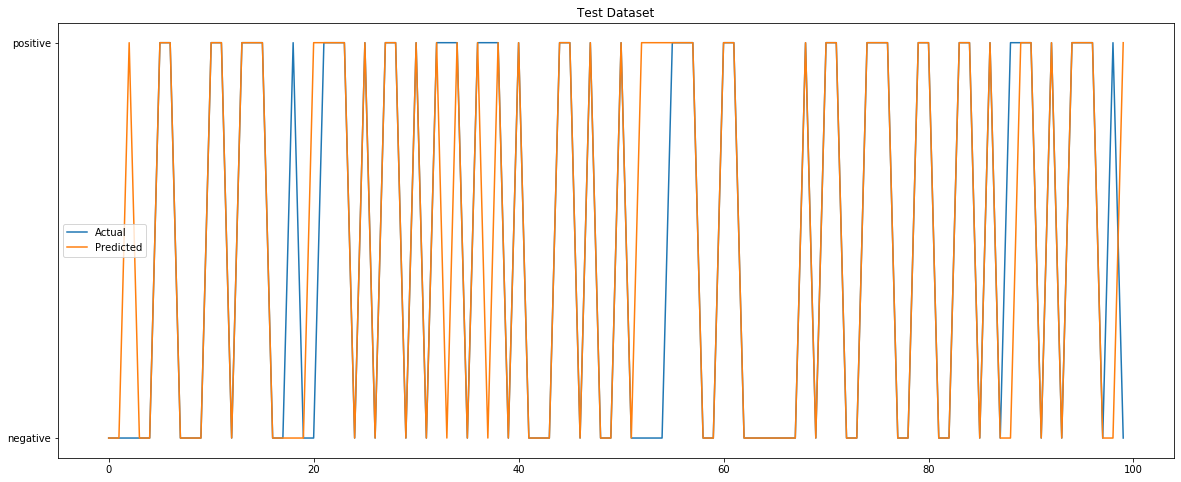

In [176]:
plt.figure(figsize=(20,8))

#Xt = model.predict(X_test)
#ax=[[series[0], series[1]]].plot()

plt.plot(series[0], label="Actual")
plt.plot(series[1], label="Predicted")
plt.legend()
plt.title("Test Dataset")

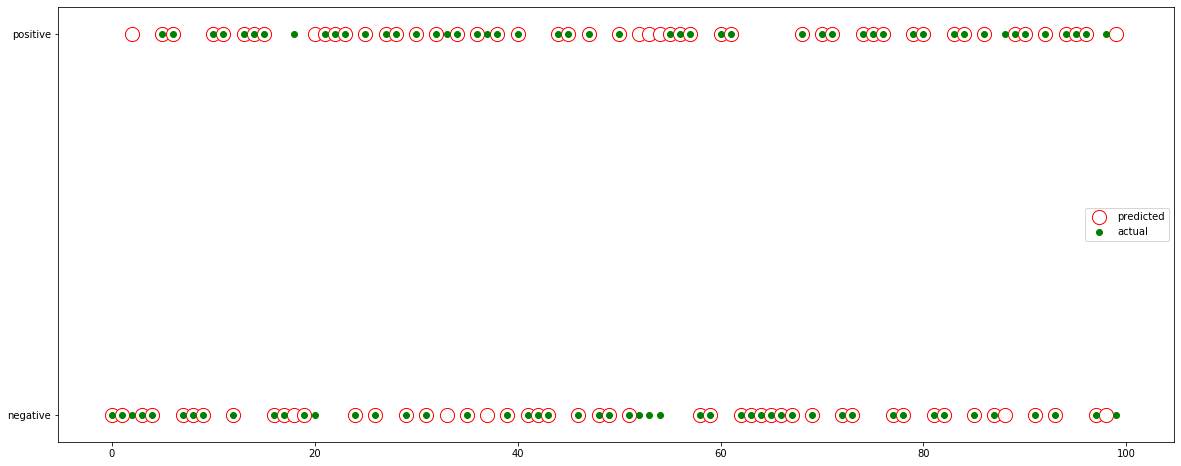

In [216]:
plt.figure(figsize=(20,8))
scatterPrediction(series[1], series[0])

In [182]:
# let us measure the accuracy of our prediction model...
def calculate_accuracy(series):
    no_match = 0
    for a,b in zip(series[0], series[1]):
        if (a != b):
            no_match += 1
    #len(series[0])
    return 100-(no_match/len(series[0])*100)
print("accuracy", calculate_accuracy(series))

accuracy 89.0


In [112]:
# predicting with stock article headlines.
data = {'content': ['Ford’s Lightning pickup could make electric vehicles popular with all consumers, not just the green ones','Global Stocks Rise After Fed’s Powell Reassures on Inflation','Alfi Inc shares set to fall from record highs, meme stock Torchlight sinks','Lemonade (LMND) Stock Sinks As Market Gains: What You Should Know','Owens & Minor (OMI) Stock Sinks As Market Gains: What You Should Know','Why Cisco Stock Could Double From Here','GSAT Stock: Why One Analyst Sees 150%+ Upside for Globalstar','Clean Energy Fuels Is Now Above and Beyond Its Meme Status','Oil Could Get to $100 a Barrel. Here Are the Stocks to Play It.','Bitcoin bounces back after erasing 2021 gains'], 'sentiment':[0,0,1,1,1,0,0,0,0,0]}

stock_df = pd.DataFrame(data)
stock_df.head()

,content,sentiment
0,Ford’s Lightning pickup could make electric ve...,0
1,Global Stocks Rise After Fed’s Powell Reassure...,0
2,"Alfi Inc shares set to fall from record highs,...",1
3,Lemonade (LMND) Stock Sinks As Market Gains: W...,1
4,Owens & Minor (OMI) Stock Sinks As Market Gain...,1


accuracy 20.0


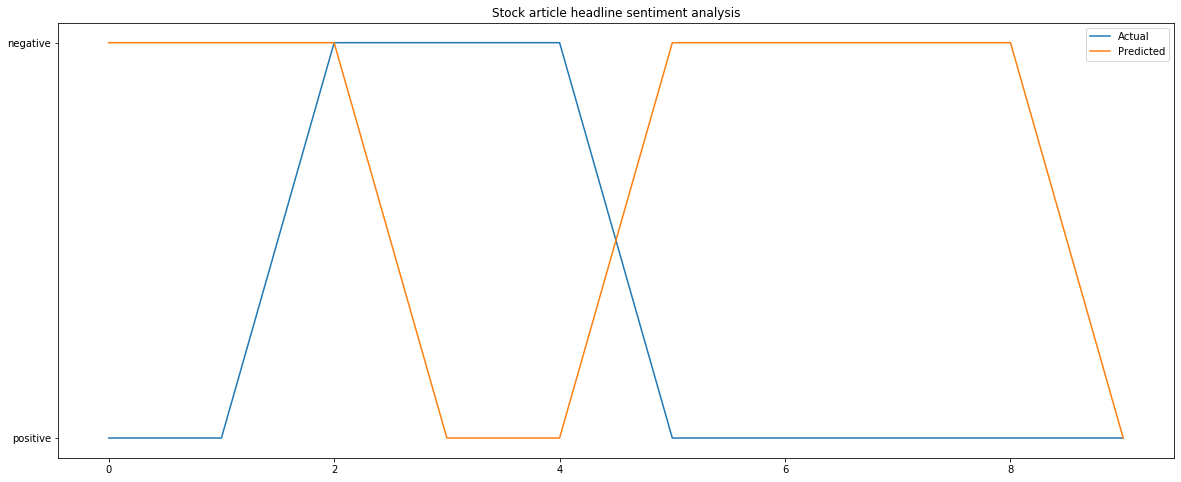

In [184]:
# Remove stopwords
removeStopwords(stock_df, 'content')
lowercase(stock_df, 'content')

stock_series = [[],[]]
for text, sentiment in zip(stock_df['content'], stock_df['sentiment']):
    analyze_sentence2(lemmatization(text), sentiment_label[1][sentiment], stock_series)

plt.figure(figsize=(20,8))

plt.plot(stock_series[0], label="Actual")
plt.plot(stock_series[1], label="Predicted")
plt.legend()
plt.title("Stock article headline sentiment analysis")

print("accuracy", calculate_accuracy(stock_series))

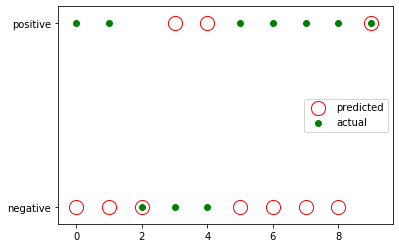

In [215]:
scatterPrediction(stock_series[1], stock_series[0])
